In [1]:
import numpy as np
import xarray as xr
from cngi.dio import read_vis
#    import dask.array as da
#    from cngi.dio import read_vis
#    import numpy as np
#    from astropy.coordinates import SkyCoord
#    import time

deg_to_rad = np.pi/180
from sirius import make_ant_sky_jones, simulation
from sirius._sirius_utils._ant_jones_term import _compute_rot_coords
from sirius._sirius_utils._calc_parallactic_angles import _calc_parallactic_angles, _find_optimal_set_angle
from sirius._sirius_utils._ant_jones_term import _rot_coord
from astropy.time import Time
from astropy.coordinates import (EarthLocation, SkyCoord, AltAz, CIRS)
import astropy.units as u
import pkg_resources
import matplotlib.pyplot as plt

# Airy

In [53]:
zpc_dir = '../data/dish_models/data/EVLA_avg_zcoeffs_SBand_lookup.zpc.zarr'
zpc_xds = xr.open_zarr(zpc_dir)
beam_models = [zpc_xds]
tel_dir = '../data/telescope_layout/data/vla.d.tel.zarr'
tel_xds = xr.open_zarr(tel_dir)
mxds = read_vis('point_source_sim_vis/mosaic_pleiades_sim_dovp_True.vis.zarr')
vis_xds = mxds.xds0
cas_vis_data = vis_xds.DATA.data.compute()

In [3]:
#########Setup parameters for uvw calculation###########
ant_pos = mxds.ANTENNA.POSITION.values # [n_ant x 3]
time_str = mxds.xds0.time.values#[0:1]        # [n_time]
site = 'VLA'
phase_center_ra_dec = mxds.FIELD.PHASE_DIR.sel(field_id=mxds.xds0.FIELD_ID.isel(baseline=0).values).values[:,0,:]

ant1 = mxds.xds0.ANTENNA1.values
ant2 = mxds.xds0.ANTENNA2.values

In [4]:
uvw_parms = {}
uvw_parms['calc_method'] = 'astropy'
uvw_parms['site'] = 'vla'
uvw_parms['auto_corr'] = False
uvw = mxds.xds0.UVW.values

In [5]:
#Create J_xds from zpc
pb_parms = {}
pb_parms['fov_scaling'] = 15
#pb_parms['fov_scaling'] = 7
#pb_parms['fov_scaling'] = 9
#pb_parms['mueller_selection'] = np.array([0])#np.arange(16) #np.array([0,5,10,15])#np.arange(16)
pb_parms['mueller_selection'] = np.arange(16)
pb_parms['zernike_freq_interp'] = 'nearest'
pb_parms['freq'] = np.array([3.00e+09])
pb_parms['pa'] = np.array([0.0, 0.7323*np.pi/4, 0.9741*np.pi/4, 0.987*np.pi/4, np.pi/4, np.pi/2])
pb_parms['image_size'] = np.array([500,500])
# time, ant, chan, pol, l, m
J_xds = make_ant_sky_jones([zpc_xds],pb_parms) #[None,None,:,:,:,:]
pol = 0
J_sub = J_xds.J.isel(model=0,pa=0,pol=pol,chan=0)

In [6]:
#Setup Beam Models
ant_pos = mxds.ANTENNA.POSITION.values
n_ant = len(ant_pos)

airy_disk_parms =  {'pb_func':'casa_airy','dish_diameter':24.5,'blockage_diameter':0.0}
beam_model_map = np.zeros(len(ant_pos), dtype=int)
#beam_models = [zpc_xds,airy_disk_parms]
beam_models = [airy_disk_parms]
#beam_models = [airy_disk_parms]
#beam_models = [airy_disk_parms,airy_disk_parms]
beam_model_map = np.zeros(n_ant,dtype=int)
#beam_model_map[1] = 1
#beam_model_map[10] = 1

beam_parms = {}
beam_parms['fov_scaling'] = 15
beam_parms['mueller_selection'] = np.arange(16)
beam_parms['zernike_freq_interp'] = 'nearest'
#beam_parms['freq'] = mxds.xds0.chan.values
beam_parms['pa_radius'] = 0.2
beam_parms['image_size'] = np.array([500,500])#np.array([2000,2000])

freq_chan = mxds.xds0.chan.values
pol = mxds.xds0.pol.values

### Point Sources

In [7]:
pointing_ra_dec = None #np.zeros((1, 1, 2)) #Singleton

#point_source_ra_dec:  [n_time, n_point_sources, 2]          (singleton: n_time)
ra = ['03h47m59.0s', '03h47m29.0s', '03h46m02.9s', '03h45m54.5s', '03h44m48.2s', '03h49m11.2s', '03h45m12.5s', '03h47m29.1s','03h49m09.7s','03h46m19.6s','03h45m49.6s', '03h44m52.5s']
dec = ['+24d29m20.0s', '+24d17m22.2s', '+24d31m40.4s', '+24d33m16.2s', '+24d17m22.1s', '+24d08m12.2s','+24d28m02.2s', '+24d06m18.5s','+24d03m12.3s','+23d56m54.1s','+24d22m03.9s','+24d06m48.0s']
point_source_skycoord = SkyCoord(ra=ra,dec=dec,frame='fk5') #sim

'''
03h47m29.1s +24d06m18.5s
03h49m09.7s +24d03m12.3s
03h46m19.6s +23d56m54.1s
03h45m49.6s +24d22m03.9s
03h44m52.5s +24d06m48.0s
'''
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad]).T[None,:,:]

In [8]:
point_source_flux = np.array([2.17, 0, 0, 2.17])[None,None,:,None] #has to be in instrument polarization: [RR,RL,LR,LL] or [XX,XY,YX,YY]. All 4 values are needed.
point_source_flux = np.tile(point_source_flux,(1,1,1,12))
point_source_flux[:, :, 0, -5:] = 3
point_source_flux[:, :, 3, -5:] = 3
point_source_flux[:, :, 0, -12:-9] = 1
point_source_flux[:, :, 3, -12:-9] = 1
pb_limit = 0.0045

In [9]:
vis_data, uvw =simulation(point_source_flux, point_source_ra_dec, pointing_ra_dec, phase_center_ra_dec, beam_parms,beam_models,beam_model_map,uvw_parms, ant_pos, time_str, freq_chan, pol, ant1, ant2, pb_limit, uvw)

[{'pb_func': 'casa_airy', 'dish_diameter': 24.5, 'blockage_diameter': 0.0}]
pol [5 8]
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


/users/mbarth/sirius/sirius/sirius/calc_vis.py:166: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 1d, A))
  flux_scaled = np.dot(M,flux)
/users/mbarth/sirius/sirius/sirius/calc_vis.py:172: NumbaWarning: Cannot cache compiled function "_apply_airy_pb" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  J_sampled = sample_J_analytic(bm1[1],bm1[2],bm1[3],lmn1,freq_chan[i_chan],1)
/users/mbarth/sirius/sirius/sirius/calc_vis.py:172: NumbaWarning: Cannot cache compiled function "_apply_casa_airy_pb" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  J_sampled = sample_J_analytic(bm1[1],bm1[2],bm1[3],lmn1,freq_chan[i_chan],1)
/users/mbarth/sirius/sirius/sirius/calc_vis.py:172: NumbaWarning: Cannot cache compiled function "sample_J_analytic" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  J_sampled = sample_J_analytic(bm1[1],bm1[2],bm1

time 21.638654947280884


# Airy Images

In [10]:
#from cngi.vis import apply_flags
from ngcasa.imaging import make_imaging_weight
from ngcasa.imaging import make_image
from ngcasa.imaging import make_pb
from cngi.dio import write_image
from ngcasa.imaging import direction_rotate
from ngcasa.imaging import make_gridding_convolution_function
from ngcasa.imaging import make_image_with_gcf
from ngcasa.imaging import make_mosaic_pb

import dask
import dask.array as da

In [11]:
rad_to_deg =  180/np.pi
deg_to_rad = np.pi/180
arcsec_to_deg = 1/3600
arcsec_to_rad = np.pi/(180*3600)

In [60]:
#mxds = apply_flags(mxds, 'xds0', flags='FLAG')
mxds.attrs['xds1'] = mxds.attrs['xds0'].isel(pol=slice(0,1))
mxds.attrs['xds1']['DATA'] = xr.DataArray(da.from_array(vis_data[:,:,:,0][:,:,:,None],chunks=mxds.attrs['xds1']['DATA'].chunks),coords=mxds.attrs['xds1']['DATA'].coords)

In [61]:
grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [1600,800]
grid_parms['cell_size'] = [5,5]

point_source_skycoord = SkyCoord(ra='03h47m29.1s',dec='+24d12m18.5s',frame='fk5')
grid_parms['phase_center'] = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])

In [62]:
sel_parms = {}
sel_parms['xds'] = 'xds1' #KEEP USING XDS1 THROUGHOUT
sel_parms['data_group_in_id'] = 0 #CHANGE TO DATA GROUP 2 AFTER ROTATION

rotation_parms = {}
rotation_parms['new_phase_center'] = grid_parms['phase_center']
rotation_parms['common_tangent_reprojection'] = True
rotation_parms['single_precision'] = False

mxds = direction_rotate(mxds, rotation_parms, sel_parms)

######################### Start direction_rotate #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
######################### Created graph for direction_rotate #########################


In [63]:
imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

sel_parms = {}
sel_parms['xds'] = 'xds1'
sel_parms['data_group_in_id'] = 2

mxds = make_imaging_weight(mxds, imaging_weights_parms, grid_parms, sel_parms)

######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'IMAGING_WEIGHT'}
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_weight #########################


In [64]:
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds1'
vis_sel_parms['data_group_in_id'] = 2

img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 0

In [65]:
write_imagegrid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [1600,800]
grid_parms['cell_size'] = [5,5]

point_source_skycoord = SkyCoord(ra='03h47m29.1s',dec='+24d12m18.5s',frame='fk5')
grid_parms['phase_center'] = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])
gcf_parms = {}
gcf_parms['function'] = 'alma_airy'
gcf_parms['list_dish_diameters'] = np.array([24.5])
gcf_parms['list_blockage_diameters'] = np.array([0])
#gcf_parms['max_support'] = [24, 24]
#gcf_parms['oversampling'] = [10, 10]
gcf_parms['max_support'] = [48, 48]
gcf_parms['oversampling'] = [10, 10]
unique_ant_indx = mxds.ANTENNA.DISH_DIAMETER.values
unique_ant_indx[unique_ant_indx == 25.0] = 0
mxds.ANTENNA.DISH_DIAMETER.values
gcf_parms['unique_ant_indx'] = unique_ant_indx.astype(int)
gcf_parms['phase_center'] = grid_parms['phase_center']
sel_parms = {}
sel_parms['xds'] = 'xds1'
sel_parms['data_group_in_id'] = 2
gcf_xds = make_gridding_convolution_function(mxds, gcf_parms, grid_parms, sel_parms)
dask.compute(gcf_xds)

######################### Start make_gridding_convolution_function #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '3', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default chan_tolerance_factor  to  0.005
Setting default support_cut_level  to  0.025
Setting default a_chan_num_chunk  to  3
Setting default image_center  to  [800 400]
Setting default fft_padding  to  1.2
#########################  Created graph for make_gridding_convolution_function #########################


(<xarray.Dataset>
 Dimensions:             (baseline: 351, chan: 3, conv_baseline: 1, conv_chan: 3, conv_pol: 1, field_id: 35, l: 1600, m: 800, pol: 1, u: 490, v: 490, xy: 2)
 Coordinates:
   * u                   (u) int64 0 1 2 3 4 5 6 ... 483 484 485 486 487 488 489
   * v                   (v) int64 0 1 2 3 4 5 6 ... 483 484 485 486 487 488 489
   * xy                  (xy) int64 0 1
   * field_id            (field_id) int64 0 1 2 3 4 5 6 ... 28 29 30 31 32 33 34
   * l                   (l) int64 0 1 2 3 4 5 ... 1594 1595 1596 1597 1598 1599
   * m                   (m) int64 0 1 2 3 4 5 6 ... 793 794 795 796 797 798 799
 Dimensions without coordinates: baseline, chan, conv_baseline, conv_chan, conv_pol, pol
 Data variables:
     SUPPORT             (conv_baseline, conv_chan, conv_pol, xy) int64 35 ... 23
     WEIGHT_CONV_KERNEL  (conv_baseline, conv_chan, conv_pol, u, v) float64 -1...
     PS_CORR_IMAGE       (l, m) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
     CF_BASELINE

In [66]:
img_xds = xr.Dataset() #empty dataset
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds1'
vis_sel_parms['data_group_in_id'] = 2

img_xds = make_mosaic_pb(mxds,gcf_xds,img_xds,vis_sel_parms,img_sel_parms,grid_parms)

######################### Start make_mosaic_pb #########################
Setting default image_center  to  [800 400]
Setting default fft_padding  to  1.2
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '3', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_in  to  {'id': '0'}
Setting default data_group_out [' pb ']  to  PB
Setting default data_group_out [' weight_pb ']  to  WEIGHT_PB
Setting default data_group_out [' weight_pb_sum_weight ']  to  WEIGHT_PB_SUM_WEIGHT
#########################  Created graph for make_mosaic_pb #########################


In [67]:
vis_select_parms = {}
vis_select_parms['xds'] = 'xds1'
vis_select_parms['data_group_in_id'] = 2

img_select_parms = {}
img_select_parms['data_group_in_id'] = 0
img_select_parms['data_group_out_id'] = 0

norm_parms = {}
norm_parms['norm_type'] = 'flat_sky'

img_xds = make_image_with_gcf(mxds,gcf_xds, img_xds, grid_parms, norm_parms, vis_select_parms, img_select_parms)

######################### Start make_image_with_gcf #########################
Setting default image_center  to  [800 400]
Setting default fft_padding  to  1.2
Setting default single_precision  to  True
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '3', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting data_group_in  to  {'id': '0', 'pb': 'PB', 'weight_pb': 'WEIGHT_PB', 'weight_pb_sum_weight': 'WEIGHT_PB_SUM_WEIGHT'}
Setting default data_group_out [' pb ']  to  PB
Setting default data_group_out [' weight_pb ']  to  WEIGHT_PB
Setting default data_group_out [' weight_pb_sum_weight ']  to  WEIGHT_PB_SUM_WEIGHT
Setting default data_group_out [' sum_weight ']  to  SUM_WEIGHT
Setting default data_group_out [' image ']  to  IMAGE
grid sizes 1920 960
#########################  Cre

(-0.5, 799.5, 1599.5, -0.5)

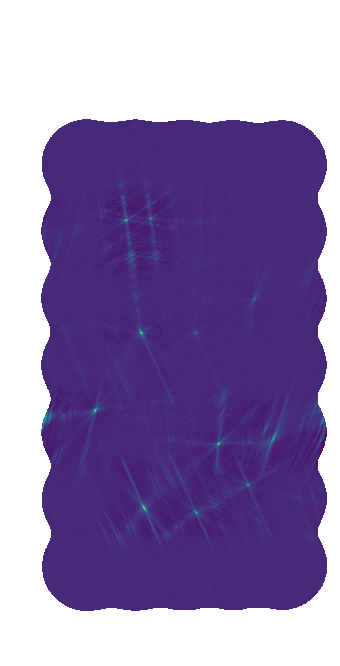

In [68]:
chan = 1
ngcasa_image_name = 'IMAGE'
pb_limit = 0.2
#extent = extent=(np.min(casa_img_xds.m),np.max(casa_img_xds.m),np.min(casa_img_xds.l),np.max(casa_img_xds.l))

mosaic_pb = img_xds.PB.isel(chan=chan)
mosaic_img = img_xds[ngcasa_image_name].isel(chan=chan)
mosaic_img = mosaic_img.where(mosaic_pb > np.max(mosaic_pb)*pb_limit,other=np.nan)

plt.figure(figsize = (12, 12))
#plt.imshow(img_xds.IMAGE.isel(chan=chan,time=0,pol=0))
plt.imshow(mosaic_img[:, :, 0, 0], vmin = -0.4)
plt.axis("off")

In [69]:
vis_data_zernike = np.load("zernike_vis_data.npy")

/users/mbarth/miniconda3/envs/casa_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/users/mbarth/miniconda3/envs/casa_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/users/mbarth/miniconda3/envs/casa_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


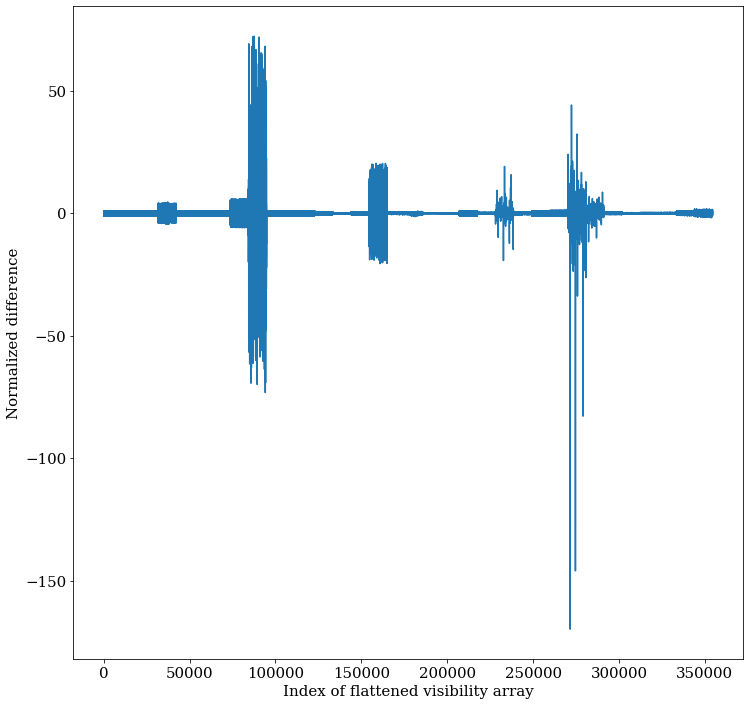

In [70]:
diff = (vis_data.flatten() - vis_data_zernike.flatten())/np.abs(vis_data.flatten())
plt.figure(figsize = (12, 12))
plt.rcParams.update({"font.size":15})
plt.rcParams.update({"font.family":"serif"})
plt.plot(diff[np.isfinite(diff)])
plt.xlabel("Index of flattened visibility array", fontsize = 15)
plt.ylabel("Normalized difference", fontsize = 15)
plt.show()

/users/mbarth/miniconda3/envs/casa_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/users/mbarth/miniconda3/envs/casa_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


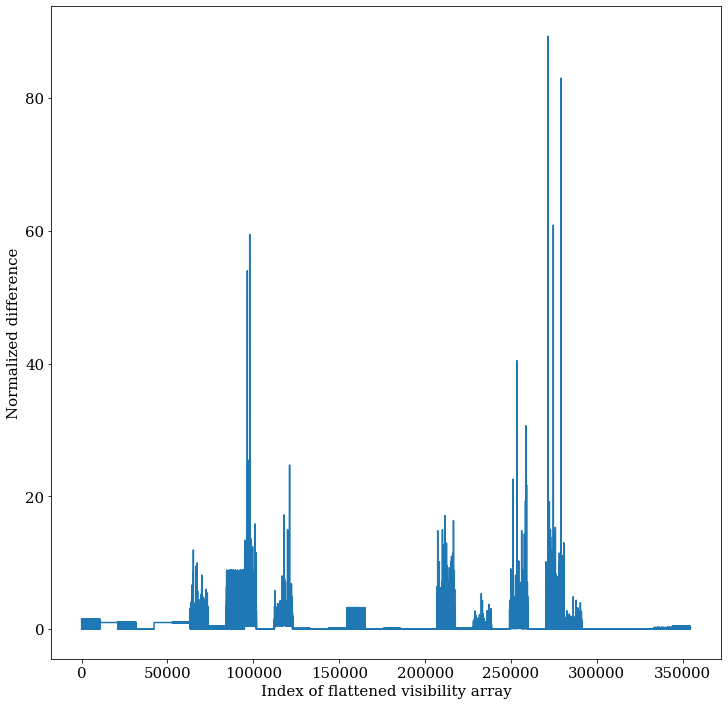

In [78]:
diff = np.ravel(np.abs(cas_vis_data[:,:,:,0]-vis_data[:,:,:,0])/np.abs(vis_data[:,:,:,0]))
plt.figure(figsize = (12, 12))
plt.rcParams.update({"font.size":15})
plt.rcParams.update({"font.family":"serif"})
plt.plot(diff[np.isfinite(diff)])
plt.xlabel("Index of flattened visibility array", fontsize = 15)
plt.ylabel("Normalized difference", fontsize = 15)
plt.show()

/users/mbarth/miniconda3/envs/casa_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/users/mbarth/miniconda3/envs/casa_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


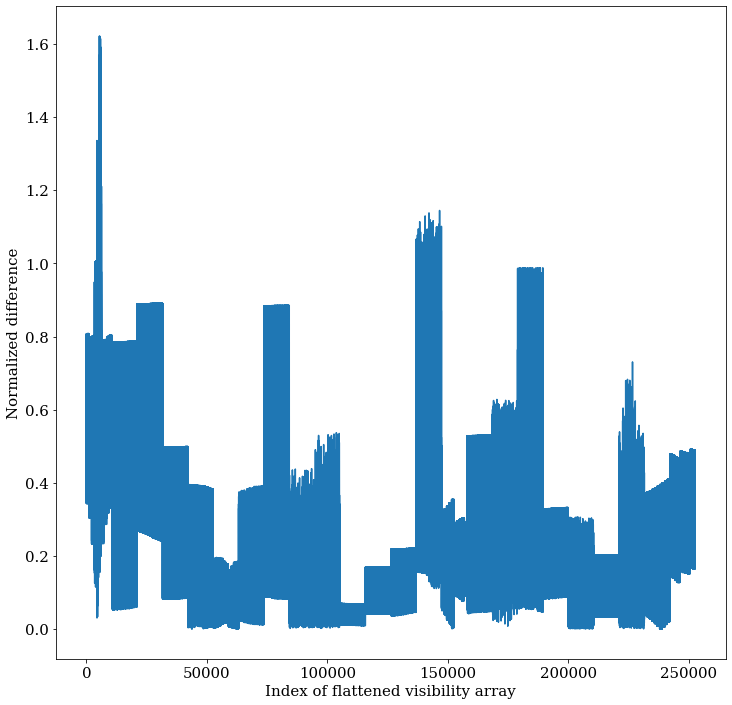

In [77]:
diff = np.ravel(np.abs(cas_vis_data[:,:,:,0]-vis_data_zernike[:,:,:,0])/np.abs(vis_data_zernike[:,:,:,0]))
plt.figure(figsize = (12, 12))
plt.rcParams.update({"font.size":15})
plt.rcParams.update({"font.family":"serif"})
plt.plot(diff[np.isfinite(diff)])
plt.xlabel("Index of flattened visibility array", fontsize = 15)
plt.ylabel("Normalized difference", fontsize = 15)
plt.show()

In [72]:
cas_vis_data.shape

(350, 351, 3, 2)

In [74]:
vis_data.shape

(350, 351, 3, 2)